# Credit Card Approval Prediction

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import xgboost as xgb
import os
import joblib
import joblib
import os
%matplotlib inline

# Load Dataset

In [2]:
# Load datasets
cc_approvals = pd.read_csv('Cleaned_application_df.csv')
cc_approvals.drop(columns=["ID", "Unnamed: 0"], inplace=True)

## Split the data into training and test sets

In [3]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [4]:
cc_train, cc_test = data_split(cc_approvals, 0.2)

In [5]:
cc_train.shape, cc_test.shape

((29165, 19), (7292, 19))

In [6]:
cc_train_copy = cc_train.copy()
cc_test_copy = cc_test.copy()

# Exploratory Data Analysis (EDA)

## Overview of the Dataset

In [13]:
# Check dataset shape
print(f"Dataset contains {cc_train_copy.shape[0]} rows and {cc_train_copy.shape[1]} columns.")

# Check column data types and missing values
print(cc_train_copy.info())

# Summary statistics
cc_train_copy.describe()

Dataset contains 29165 rows and 19 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29165 entries, 0 to 29164
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               29165 non-null  object 
 1   Has a car            29165 non-null  object 
 2   Has a property       29165 non-null  object 
 3   Children count       29165 non-null  int64  
 4   Income               29165 non-null  float64
 5   Employment status    29165 non-null  object 
 6   Education level      29165 non-null  object 
 7   Marital status       29165 non-null  object 
 8   Dwelling             29165 non-null  object 
 9   Age                  29165 non-null  int64  
 10  Employment length    29165 non-null  int64  
 11  Has a mobile phone   29165 non-null  object 
 12  Has a work phone     29165 non-null  object 
 13  Has a phone          29165 non-null  object 
 14  Has an email         29165 non-null  objec

,Children count,Income,Age,Employment length,Family member count,Account age,Is high risk
count,29165.000000,2.916500e+04,29165.000000,29165.00000,29165.000000,29165.000000,29165.000000
mean,0.430790,1.868904e+05,43.271113,5.63151,2.197531,26.137734,0.017110
std,0.741882,1.014096e+05,11.516459,6.42824,0.912189,16.486702,0.129682
min,0.000000,2.700000e+04,21.000000,0.00000,1.000000,-0.000000,0.000000
25%,0.000000,1.215000e+05,34.000000,1.00000,2.000000,12.000000,0.000000
50%,0.000000,1.575000e+05,42.000000,4.00000,2.000000,24.000000,0.000000
75%,1.000000,2.250000e+05,53.000000,8.00000,3.000000,39.000000,0.000000
max,19.000000,1.575000e+06,68.000000,43.00000,20.000000,60.000000,1.000000


## Numerical Features Distribution

- Outliers
- Skewness

In [14]:
def univariate_analysis(data):
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.drop(['Is high risk'], errors='ignore')

    for column in numeric_columns:
        print(f'\nAnalysis for {column}:\n')
        print(data[column].describe())
        
        plt.figure(figsize=(12, 6))
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(data[column], kde=True, bins=30)
        plt.title(f'Histogram of {column}')
        
        # Box Plot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=data[column])
        plt.title(f'Box Plot of {column}')
        
        plt.tight_layout()
        plt.show()


Analysis for Children count:

count    29165.000000
mean         0.430790
std          0.741882
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: Children count, dtype: float64


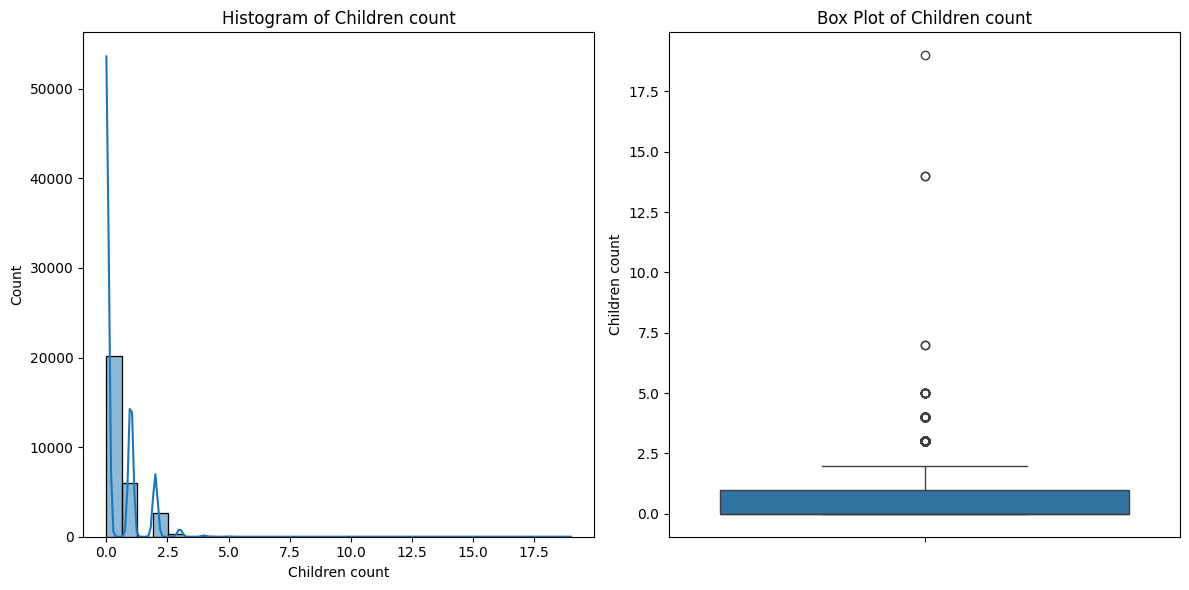


Analysis for Income:

count    2.916500e+04
mean     1.868904e+05
std      1.014096e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: Income, dtype: float64


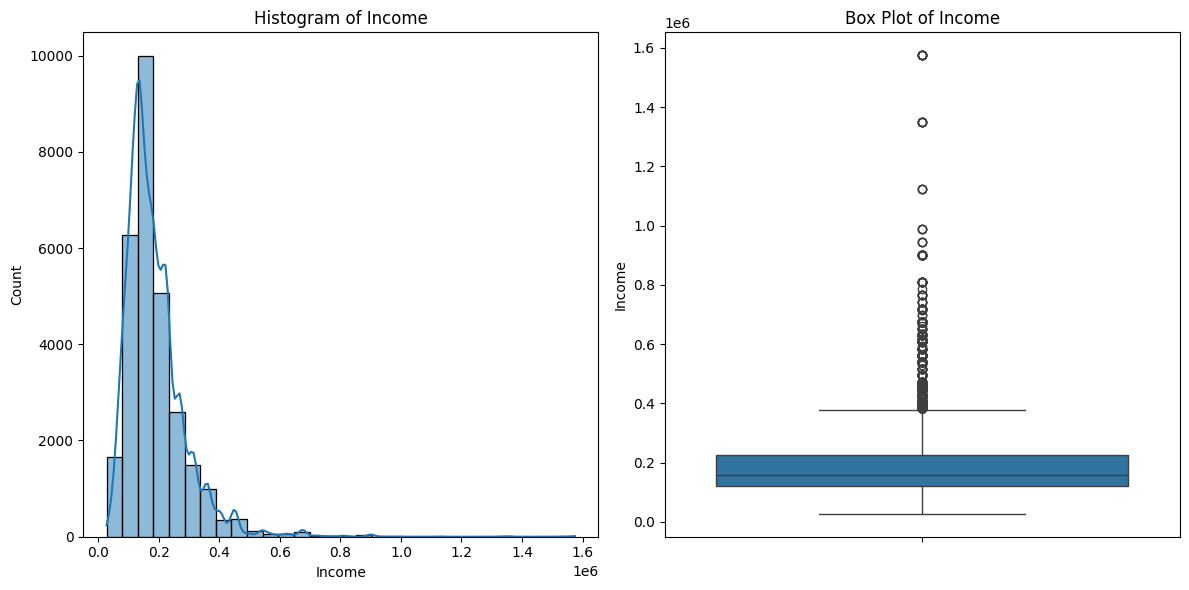


Analysis for Age:

count    29165.000000
mean        43.271113
std         11.516459
min         21.000000
25%         34.000000
50%         42.000000
75%         53.000000
max         68.000000
Name: Age, dtype: float64


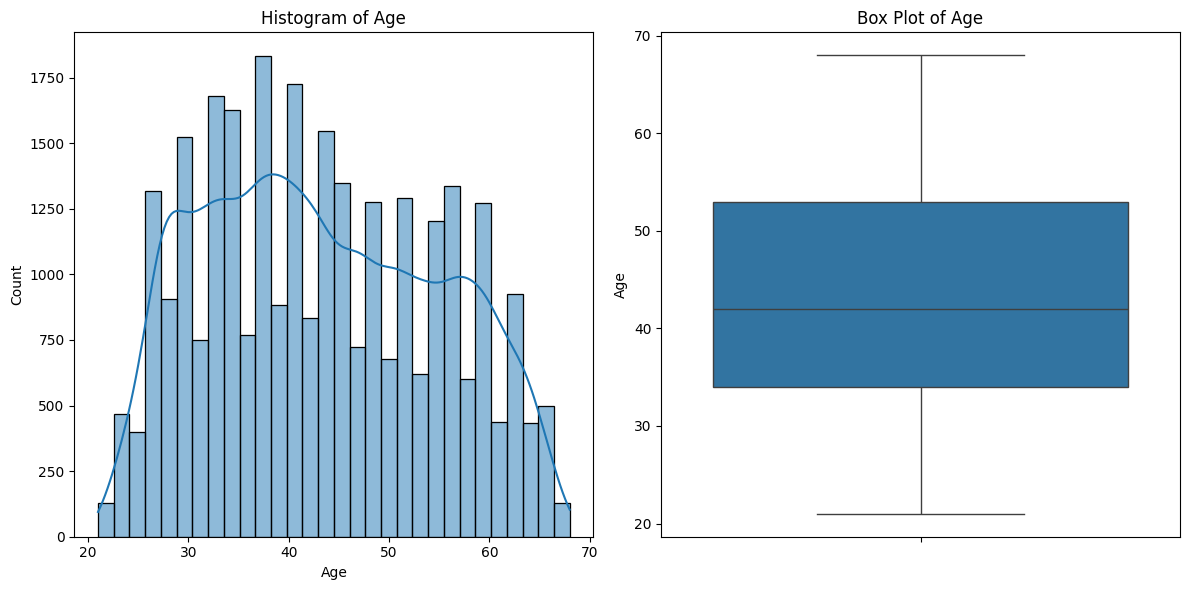


Analysis for Employment length:

count    29165.00000
mean         5.63151
std          6.42824
min          0.00000
25%          1.00000
50%          4.00000
75%          8.00000
max         43.00000
Name: Employment length, dtype: float64


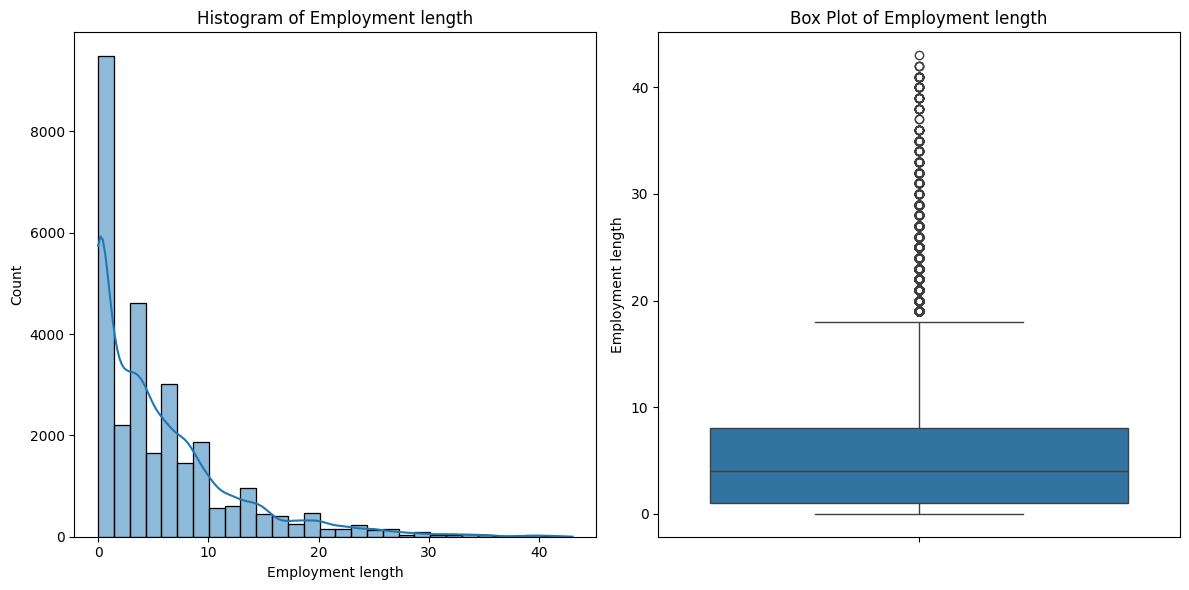


Analysis for Family member count:

count    29165.000000
mean         2.197531
std          0.912189
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family member count, dtype: float64


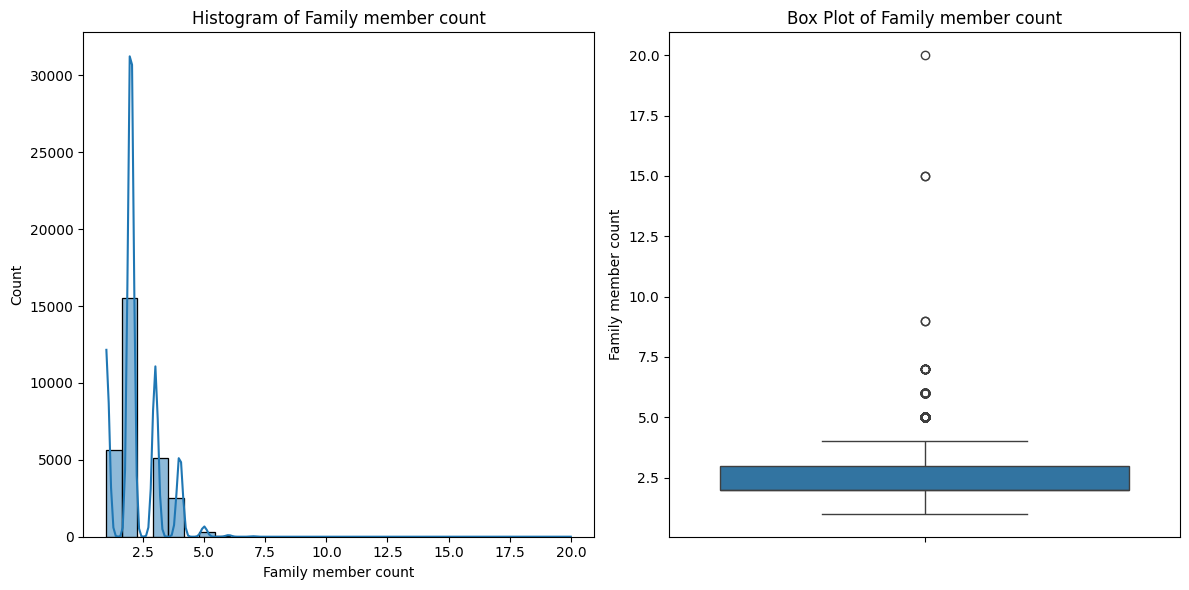


Analysis for Account age:

count    29165.000000
mean        26.137734
std         16.486702
min         -0.000000
25%         12.000000
50%         24.000000
75%         39.000000
max         60.000000
Name: Account age, dtype: float64


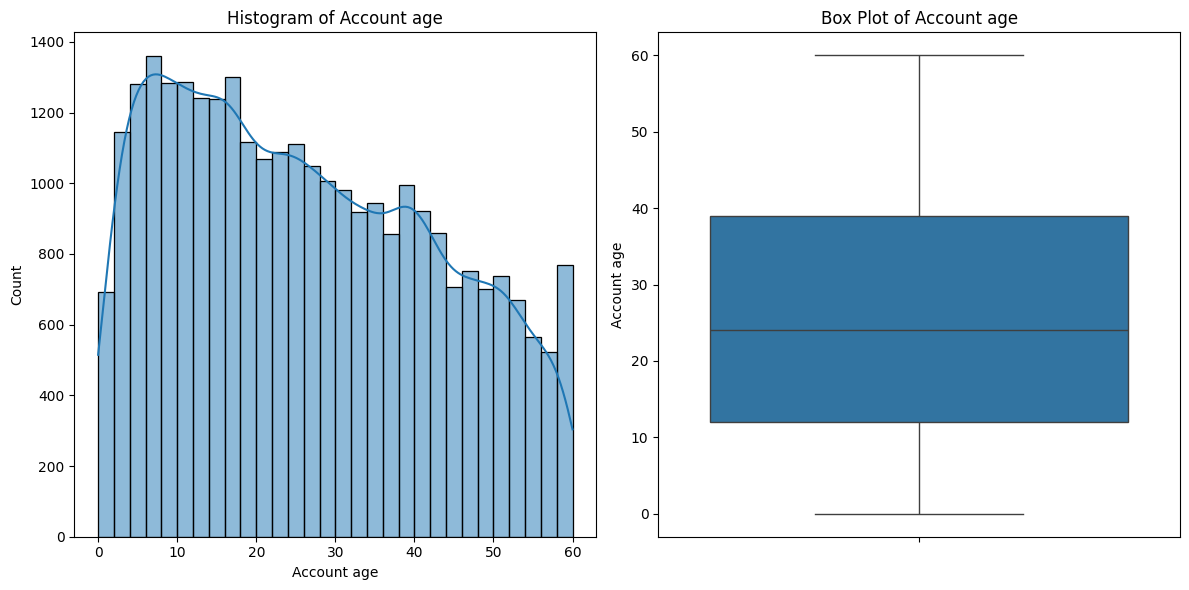

In [15]:
univariate_analysis(cc_train_copy)

# Prepare the data

* Drop features
* One hot encoding
* Min-max scaling
* Fix skewness
* Remove outliers
* Ordinal encoding
* balance the data with SMOTE

In [7]:
def preprocess_data(df, is_train=True, target_column=None, 
                    outlier_cols=None, skewness_cols=None, scale_cols=None, 
                    balance_data=False, ordinal_cols=None, ordinal_mapping=None,
                    binning_cols=None, drop_cols=None, one_hot_cols=None):
    """
    Function to preprocess data: handle missing values, drop columns, outliers, skewness,
    feature scaling, one-hot encoding for specified categorical features, ordinal encoding, binning,
    and class imbalance handling.
    """
    df = df.copy()

    # Drop specified unnecessary columns
    if drop_cols:
        df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    # Drop missing values
    df.dropna(inplace=True)

    # Exclude target column from numeric transformations
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_column and target_column in numeric_cols:
        numeric_cols.remove(target_column)

    # Binning (convert "Yes" to 1, "No" to 0)
    if binning_cols:
        for col in binning_cols:
            if col in df.columns:
                df[col] = df[col].map({'Yes': 1, 'No': 0})
                df[col] = df[col].fillna(0)

    # Outlier removal
    if outlier_cols:
        for col in outlier_cols:
            if col in df.columns:
                lower, upper = np.percentile(df[col], [1, 99])
                df = df[(df[col] >= lower) & (df[col] <= upper)]

    # Skewness correction
    if skewness_cols:
        for col in skewness_cols:
            if col in df.columns:
                df[col] = np.log1p(df[col])

    # Feature Scaling
    if scale_cols:
        scaler = MinMaxScaler()
        df[scale_cols] = scaler.fit_transform(df[scale_cols])

    # Ordinal Encoding
    if ordinal_cols and ordinal_mapping:
        encoder = OrdinalEncoder(categories=[ordinal_mapping[col] for col in ordinal_cols])
        df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols])

    # One-Hot Encoding for specified categorical columns
    if one_hot_cols:
        encoder = OneHotEncoder(sparse_output=False, drop=None)
        encoded = encoder.fit_transform(df[one_hot_cols])
        encoded_cols = encoder.get_feature_names_out(one_hot_cols)
        encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)
        df.drop(columns=one_hot_cols, inplace=True)
        df = pd.concat([df, encoded_df], axis=1)

    # Handle class imbalance using SMOTE
    if is_train and balance_data and target_column:
        X = df.drop(columns=[target_column])
        y = df[target_column]

        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        df = pd.DataFrame(X_resampled, columns=X.columns)
        df[target_column] = y_resampled

    return df

In [8]:
# Define columns for each transformation
outlier_cols = ['Family member count','Income', 'Employment length']
drop_cols=['Has a mobile phone','Children count','Job title','Account age', 'Has a phone', 'Has a work phone', 'Has an email']
skewness_cols = ['Income','Age']
binning_cols=['Has a car', 'Has a property']
one_hot_cols=['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property']
ordinal_cols=['Education level']
ordinal_mapping={'Education level': ['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Higher education', 'Academic degree']}
scale_cols = ['Age', 'Income', 'Employment length']

## Data Preprocessing

In [9]:
train_cleaned = preprocess_data(cc_train, is_train=True, target_column='Is high risk', 
                    outlier_cols=outlier_cols, drop_cols=drop_cols, skewness_cols=skewness_cols, 
                    binning_cols=binning_cols, one_hot_cols=one_hot_cols, ordinal_cols=ordinal_cols, ordinal_mapping=ordinal_mapping, scale_cols=None, 
                    balance_data=True)

In [10]:
pd.set_option('display.max_columns', None)
train_cleaned.head()

,Income,Education level,Age,Employment length,Family member count,Gender_Female,Gender_Male,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Dwelling_Co-op apartment,Dwelling_House / apartment,Dwelling_Municipal apartment,Dwelling_Office apartment,Dwelling_Rented apartment,Dwelling_With parents,Employment status_Commercial associate,Employment status_Pensioner,Employment status_State servant,Employment status_Student,Employment status_Working,Has a car_0,Has a car_1,Has a property_0,Has a property_1,Is high risk
0,11.813037,1.0,3.806662,8,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0
1,11.813037,3.0,3.332205,4,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
2,12.100718,1.0,3.583519,15,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,12.793862,3.0,4.060443,5,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
4,12.506181,1.0,3.806662,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0


In [43]:
train_cleaned['Is high risk'].value_counts()

Is high risk
0    27814
1    27814
Name: count, dtype: int64

In [44]:
# split the train data into X and y (target)
X_train_prep, y_train_prep = train_cleaned.loc[:, train_cleaned.columns != 'Is high risk'], train_cleaned['Is high risk'].astype('int64')

## Model Training

In [47]:
def evaluate_model(model, X_train, y_train, class_names):
    """
    Train the model using cross-validation and generate classification report, ROC Curve, confusion matrix,
    Precision-Recall Curve, and Feature Importance.
    """
    # Cross-validation predictions
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_train, y_train, cv=kf, method="predict")
    y_prob = cross_val_predict(model, X_train, y_train, cv=kf, method="predict_proba") if hasattr(model, 'predict_proba') else None
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_train, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_train, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve
    if y_prob is not None:
        y_train_bin = label_binarize(y_train, classes=[0, 1])
        fpr, tpr, _ = roc_curve(y_train_bin, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()
    
    # Precision-Recall Curve
    if y_prob is not None:
        precision, recall, _ = precision_recall_curve(y_train, y_prob[:, 1])
        avg_precision = average_precision_score(y_train, y_prob[:, 1])
        
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()
    
    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(len(importances))]
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        
        # Display top 10 and bottom 10
        print("Top 10 Features:")
        print(importance_df.head(10))
        print("\nBottom 10 Features:")
        print(importance_df.tail(10))
        
        # Plot top 10
        top_10 = importance_df.head(10)
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')
        plt.title('Top 10 Feature Importance')
        plt.show()
        
        # Plot bottom 10
        bottom_10 = importance_df.tail(10)
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=bottom_10, palette='viridis')
        plt.title('Bottom 10 Feature Importance')
        plt.show()
    
    return model

In [48]:
# Define base models
log_clf = LogisticRegression(random_state=42, max_iter=1000)
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define ensemble models
voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rf_clf),
        ('xgb', xgb_clf)
    ],
    voting='soft'  # soft voting uses predicted probabilities
)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('gb', gb_clf),
        ('xgb', xgb_clf)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True
)


==== Training and Evaluating LogisticRegression ====
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.53      0.55     27814
           1       0.56      0.60      0.58     27814

    accuracy                           0.56     55628
   macro avg       0.56      0.56      0.56     55628
weighted avg       0.56      0.56      0.56     55628



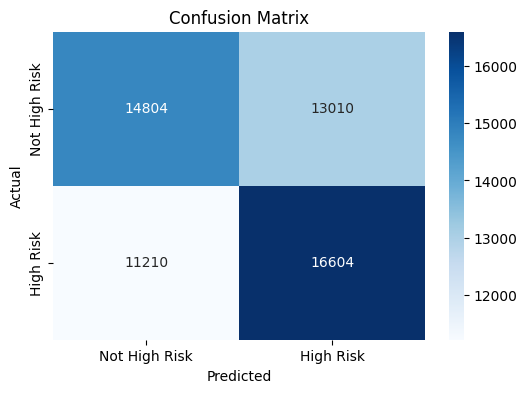

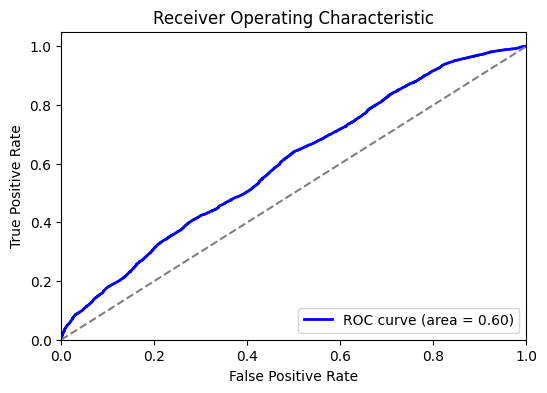

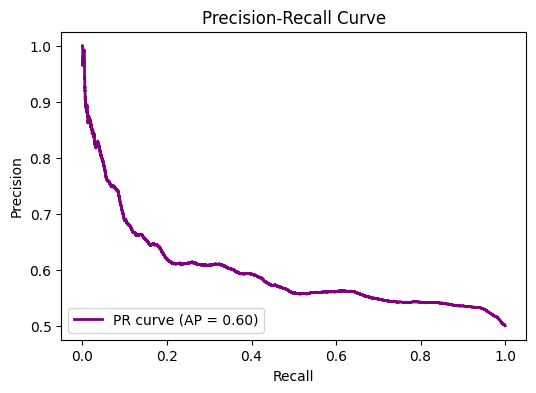

Model saved to: models\LogisticRegression_model.pkl

==== Training and Evaluating DecisionTree ====
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     27814
           1       0.99      0.98      0.98     27814

    accuracy                           0.98     55628
   macro avg       0.98      0.98      0.98     55628
weighted avg       0.98      0.98      0.98     55628



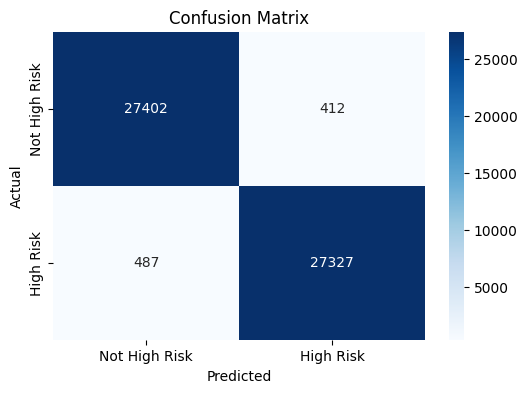

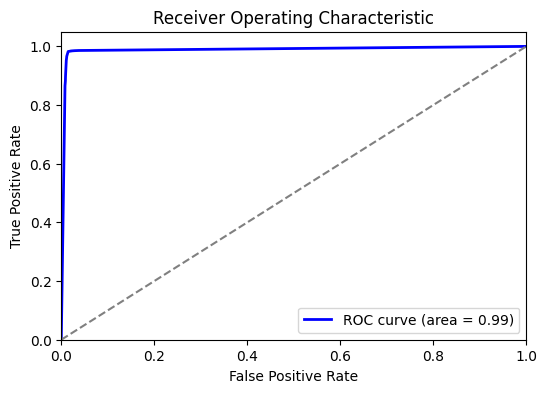

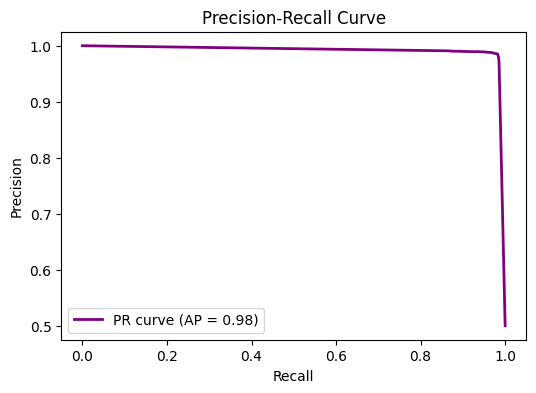

Top 10 Features:
                                   Feature  Importance
0                                   Income    0.157649
2                                      Age    0.134309
3                        Employment length    0.119882
4                      Family member count    0.104220
25                        Has a property_0    0.053436
1                          Education level    0.044593
18  Employment status_Commercial associate    0.042050
10     Marital status_Single / not married    0.031611
20         Employment status_State servant    0.030567
5                            Gender_Female    0.029905

Bottom 10 Features:
                          Feature  Importance
7   Marital status_Civil marriage    0.014163
11           Marital status_Widow    0.013423
17          Dwelling_With parents    0.012198
13     Dwelling_House / apartment    0.011303
14   Dwelling_Municipal apartment    0.010706
19    Employment status_Pensioner    0.009838
16      Dwelling_Rented apartment  

C:\Users\User\AppData\Local\Temp\ipykernel_8028\2210154315.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')


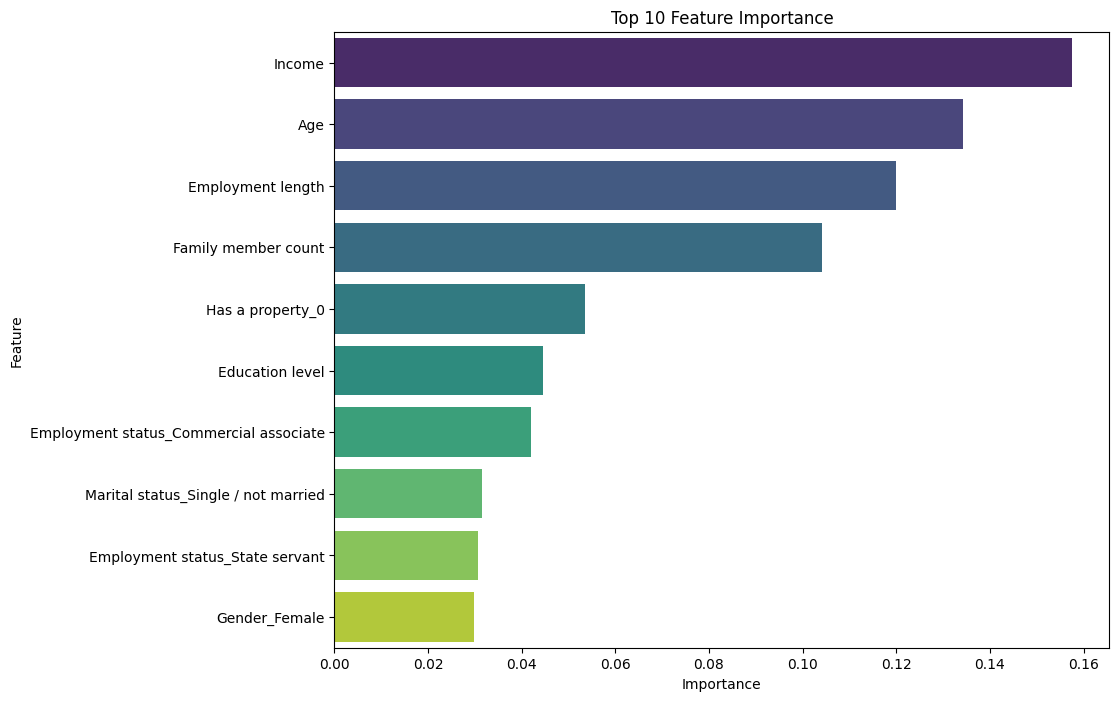

C:\Users\User\AppData\Local\Temp\ipykernel_8028\2210154315.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=bottom_10, palette='viridis')


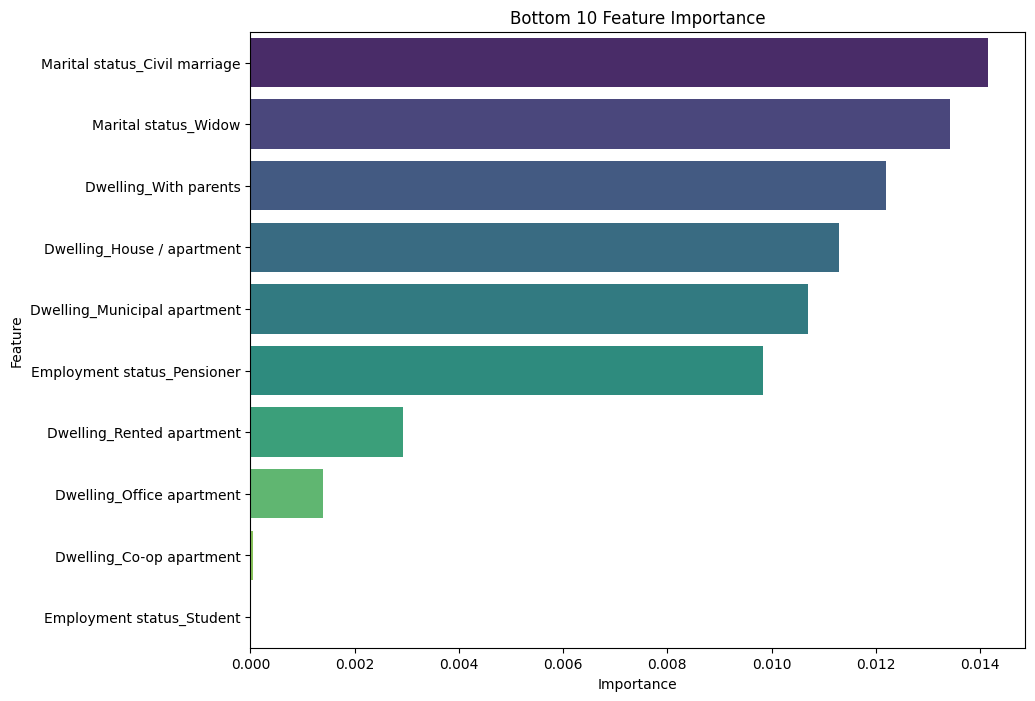

Model saved to: models\DecisionTree_model.pkl

==== Training and Evaluating RandomForest ====
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27814
           1       0.99      0.99      0.99     27814

    accuracy                           0.99     55628
   macro avg       0.99      0.99      0.99     55628
weighted avg       0.99      0.99      0.99     55628



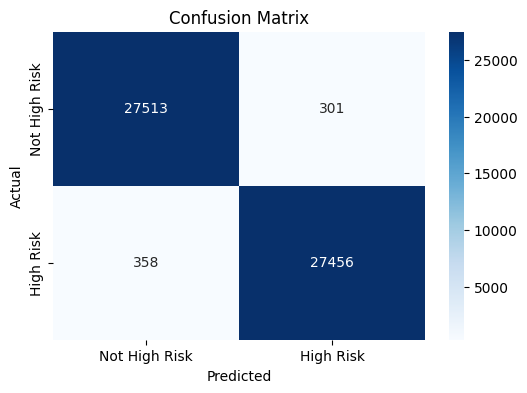

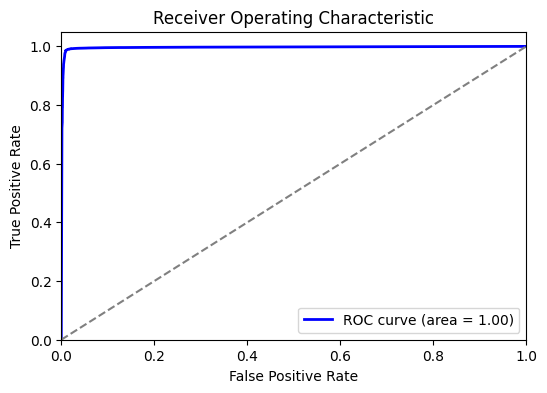

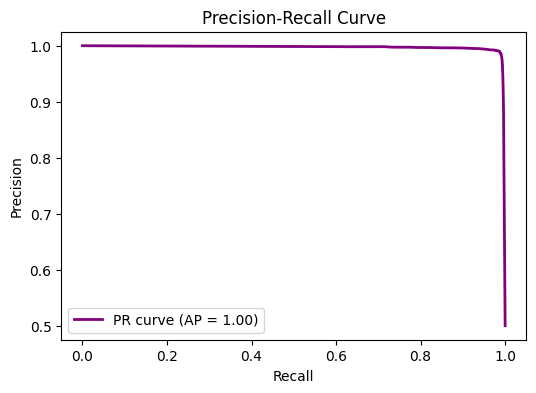

Top 10 Features:
                                   Feature  Importance
0                                   Income    0.148014
2                                      Age    0.146064
3                        Employment length    0.112370
4                      Family member count    0.080223
18  Employment status_Commercial associate    0.047328
1                          Education level    0.046611
25                        Has a property_0    0.038481
26                        Has a property_1    0.037084
24                             Has a car_1    0.033674
8                   Marital status_Married    0.032603

Bottom 10 Features:
                          Feature  Importance
7   Marital status_Civil marriage    0.020058
19    Employment status_Pensioner    0.016542
9        Marital status_Separated    0.016082
11           Marital status_Widow    0.008045
17          Dwelling_With parents    0.007539
14   Dwelling_Municipal apartment    0.007391
16      Dwelling_Rented apartment  

C:\Users\User\AppData\Local\Temp\ipykernel_8028\2210154315.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')


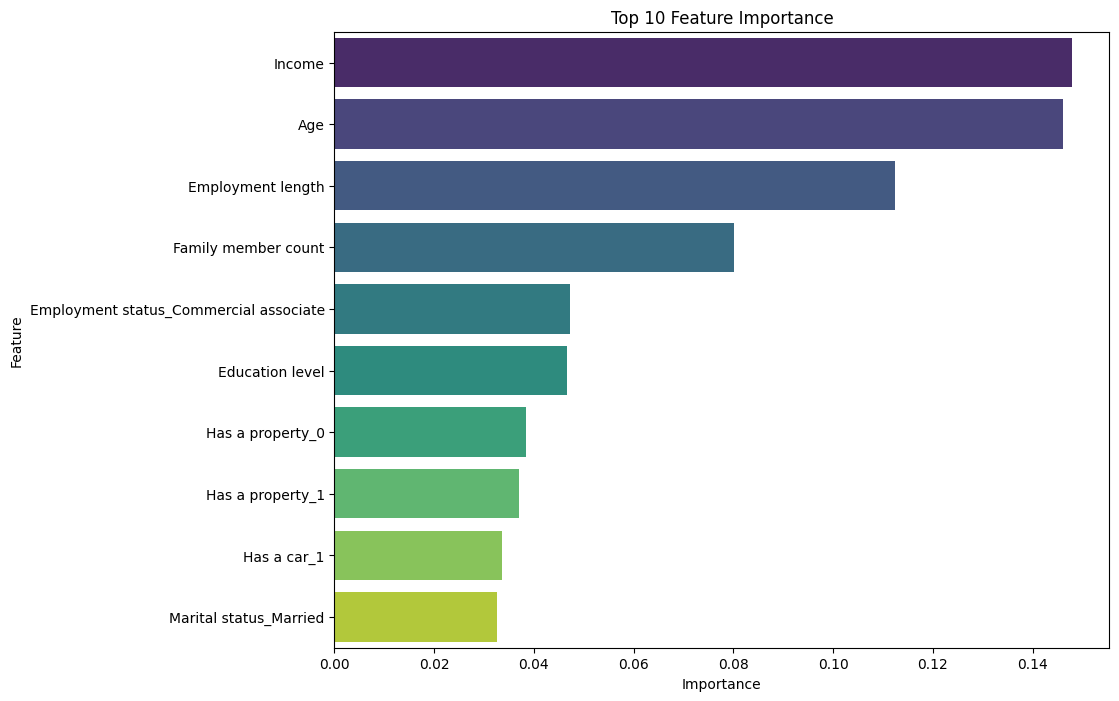

C:\Users\User\AppData\Local\Temp\ipykernel_8028\2210154315.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=bottom_10, palette='viridis')


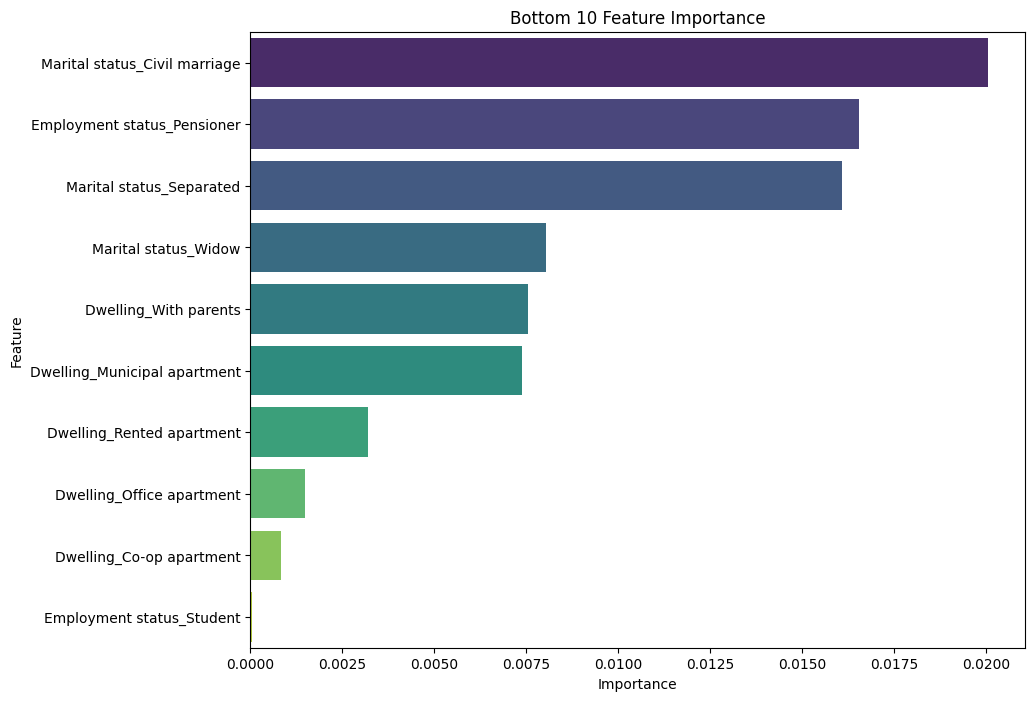

Model saved to: models\RandomForest_model.pkl

==== Training and Evaluating GradientBoosting ====
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     27814
           1       0.92      0.83      0.87     27814

    accuracy                           0.88     55628
   macro avg       0.88      0.88      0.88     55628
weighted avg       0.88      0.88      0.88     55628



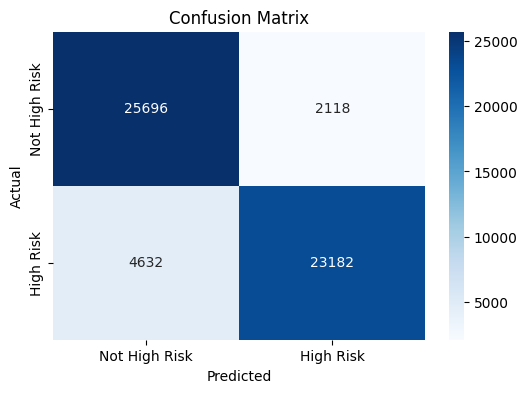

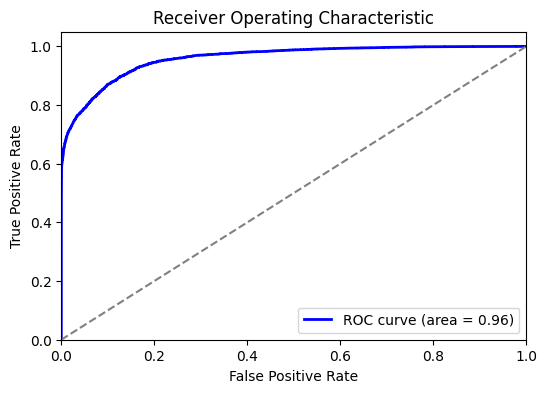

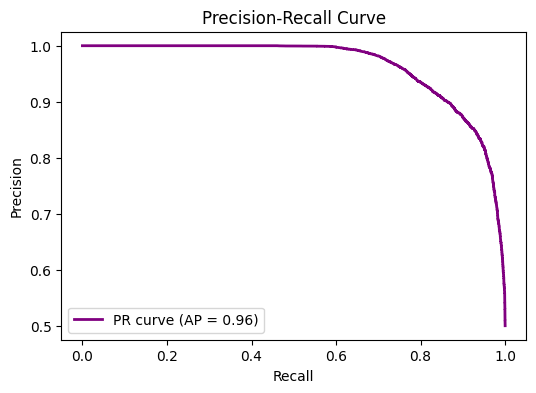

Top 10 Features:
                                   Feature  Importance
0                                   Income    0.119754
18  Employment status_Commercial associate    0.101156
2                                      Age    0.098935
3                        Employment length    0.086946
4                      Family member count    0.075966
20         Employment status_State servant    0.061262
26                        Has a property_1    0.059020
25                        Has a property_0    0.058010
8                   Marital status_Married    0.051854
6                              Gender_Male    0.048157

Bottom 10 Features:
                         Feature  Importance
5                  Gender_Female    0.015501
11          Marital status_Widow    0.013328
22     Employment status_Working    0.005892
19   Employment status_Pensioner    0.004308
16     Dwelling_Rented apartment    0.003427
14  Dwelling_Municipal apartment    0.001380
17         Dwelling_With parents    0.0008

C:\Users\User\AppData\Local\Temp\ipykernel_8028\2210154315.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')


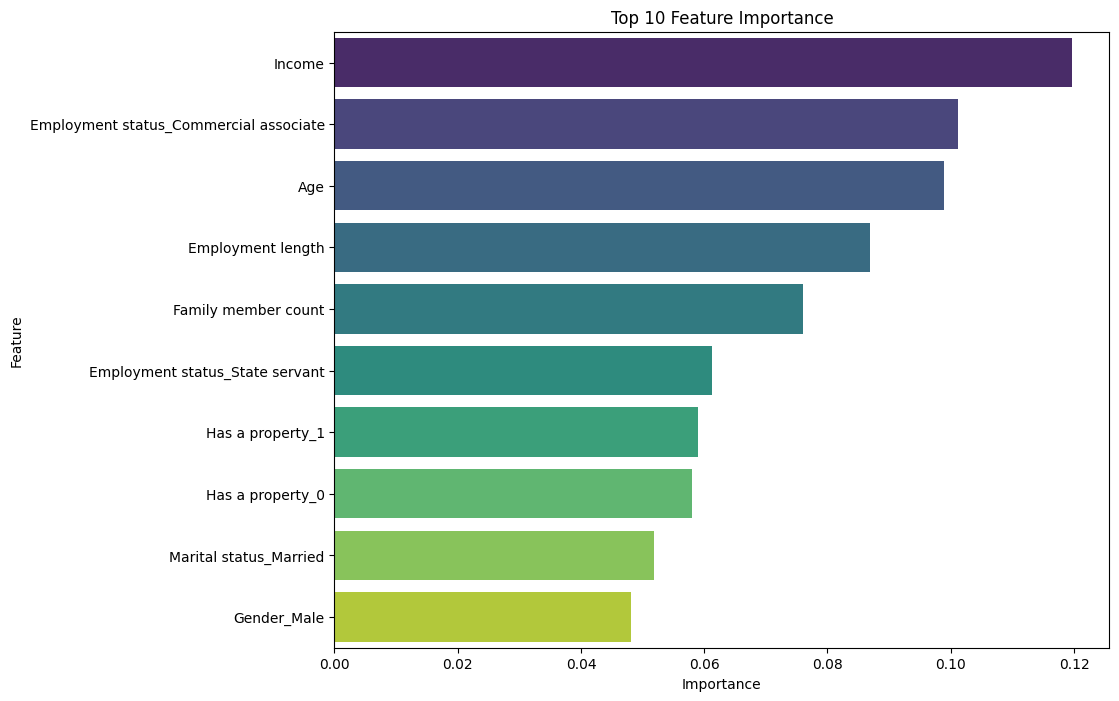

C:\Users\User\AppData\Local\Temp\ipykernel_8028\2210154315.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=bottom_10, palette='viridis')


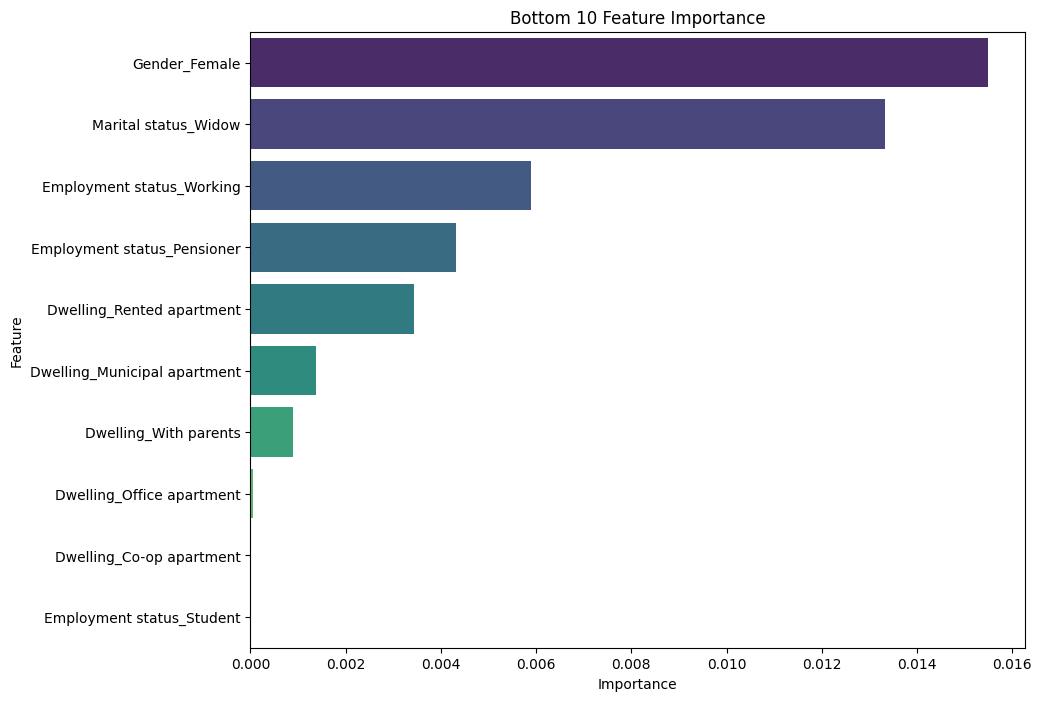

Model saved to: models\GradientBoosting_model.pkl

==== Training and Evaluating XGBoost ====


c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Classification\Credit Card Approval Prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:04:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Classification\Credit Card Approval Prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:04:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Classification\Credit Card Approval Prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:04:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     27814
           1       0.98      0.98      0.98     27814

    accuracy                           0.98     55628
   macro avg       0.98      0.98      0.98     55628
weighted avg       0.98      0.98      0.98     55628



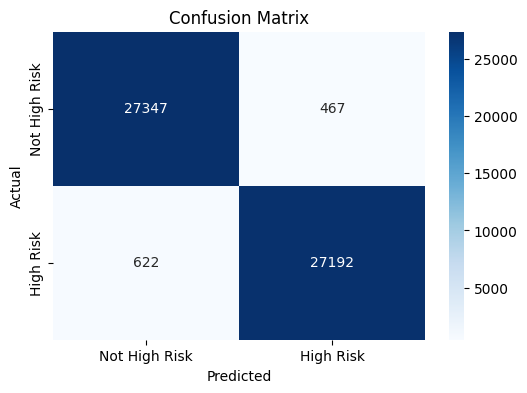

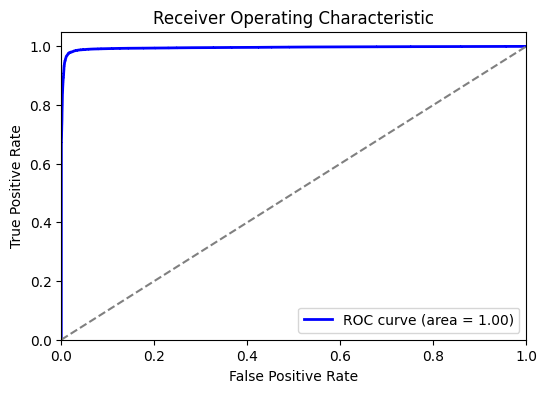

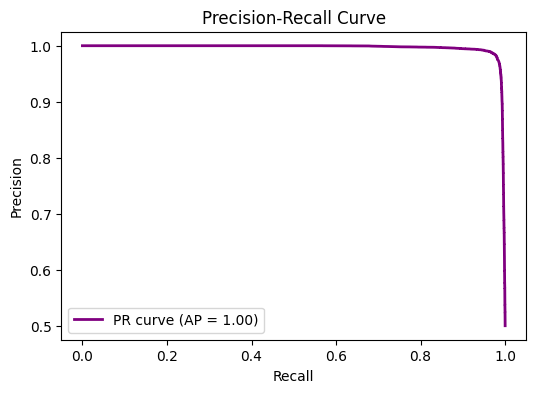

Top 10 Features:
                                   Feature  Importance
26                        Has a property_1    0.340201
20         Employment status_State servant    0.070783
6                              Gender_Male    0.064774
7            Marital status_Civil marriage    0.045324
13              Dwelling_House / apartment    0.042435
18  Employment status_Commercial associate    0.041995
10     Marital status_Single / not married    0.041325
24                             Has a car_1    0.035188
9                 Marital status_Separated    0.034739
8                   Marital status_Married    0.029850

Bottom 10 Features:
                         Feature  Importance
3              Employment length    0.015758
1                Education level    0.015335
17         Dwelling_With parents    0.014953
14  Dwelling_Municipal apartment    0.014372
2                            Age    0.013788
22     Employment status_Working    0.011516
16     Dwelling_Rented apartment    0.0085

C:\Users\User\AppData\Local\Temp\ipykernel_8028\2210154315.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')


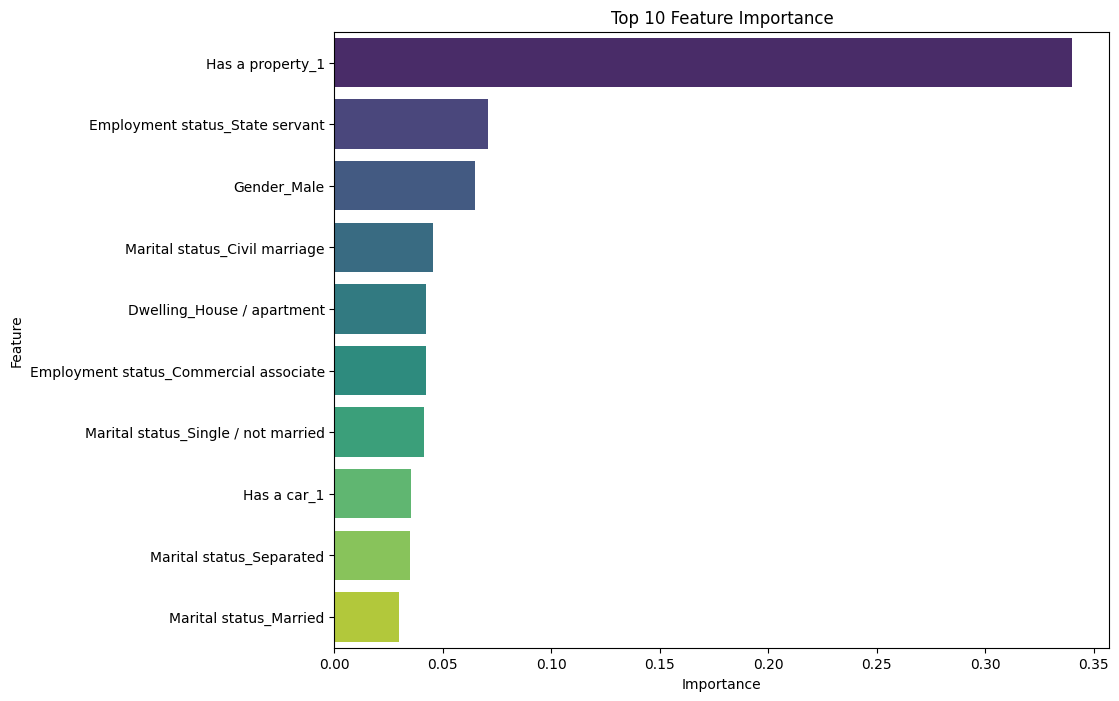

C:\Users\User\AppData\Local\Temp\ipykernel_8028\2210154315.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=bottom_10, palette='viridis')


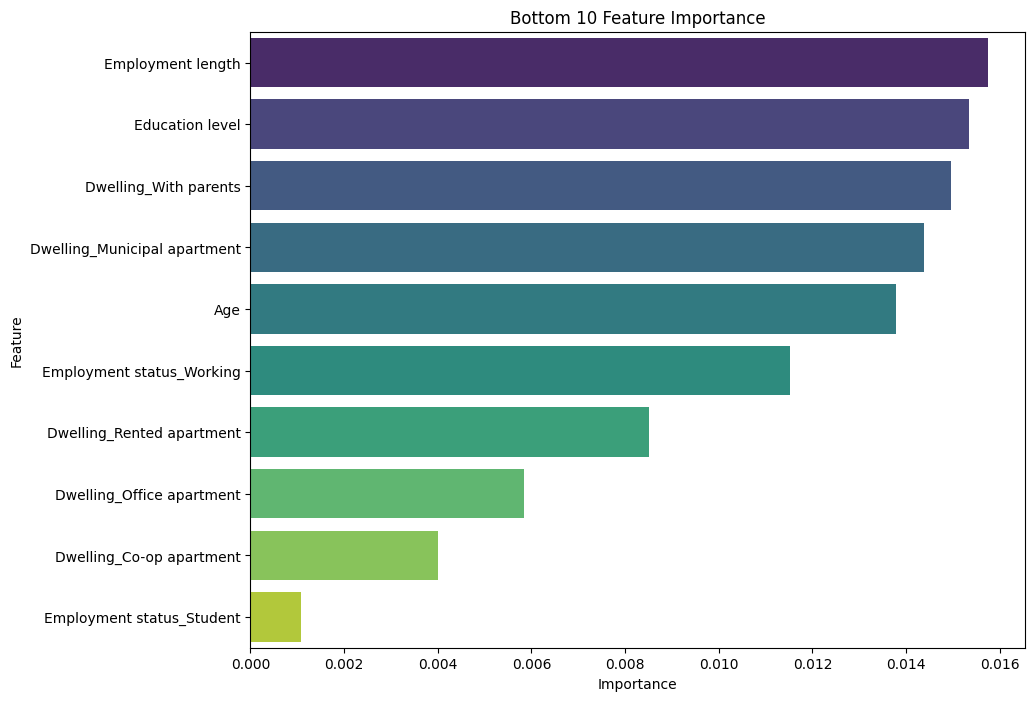

Model saved to: models\XGBoost_model.pkl

==== Training and Evaluating VotingClassifier ====


c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Classification\Credit Card Approval Prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:07:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Classification\Credit Card Approval Prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:08:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Classification\Credit Card Approval Prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:10:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27814
           1       0.99      0.99      0.99     27814

    accuracy                           0.99     55628
   macro avg       0.99      0.99      0.99     55628
weighted avg       0.99      0.99      0.99     55628



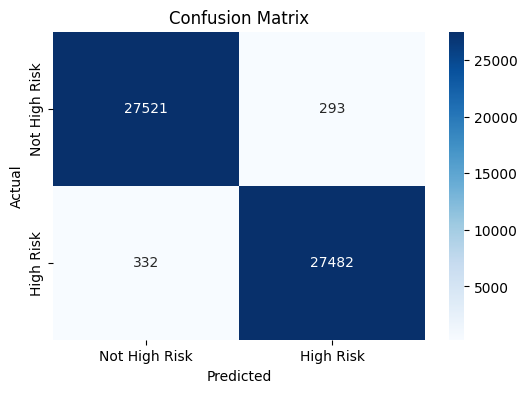

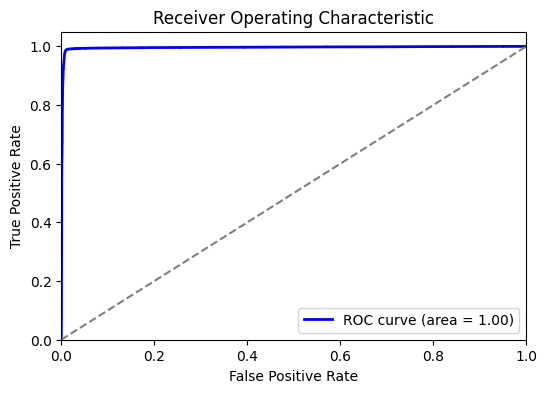

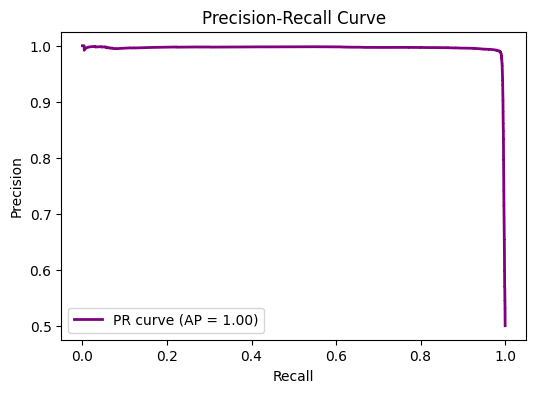

Model saved to: models\VotingClassifier_model.pkl

==== Training and Evaluating StackingClassifier ====


c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Classification\Credit Card Approval Prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:29:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Classification\Credit Card Approval Prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:37:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Classification\Credit Card Approval Prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:37:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27814
           1       0.99      0.99      0.99     27814

    accuracy                           0.99     55628
   macro avg       0.99      0.99      0.99     55628
weighted avg       0.99      0.99      0.99     55628



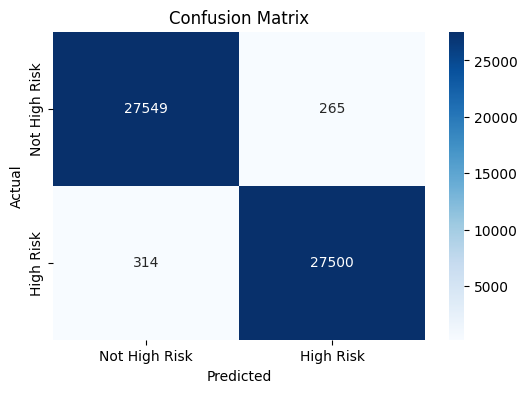

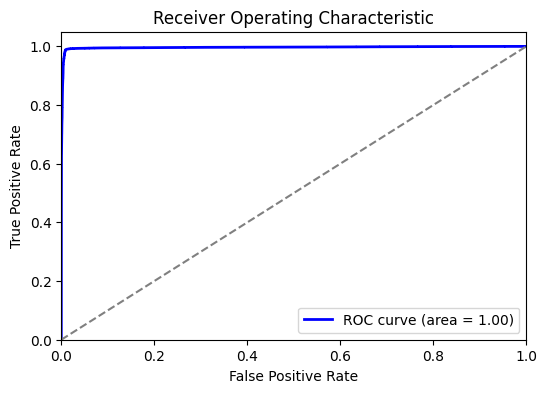

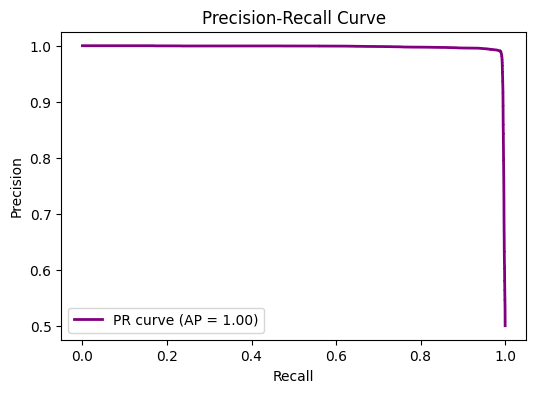

Model saved to: models\StackingClassifier_model.pkl


In [49]:
# Define models dictionary including ensemble models
models = {
    "LogisticRegression": log_clf,
    "DecisionTree": dt_clf,
    "RandomForest": rf_clf,
    "GradientBoosting": gb_clf,
    "XGBoost": xgb_clf,
    "VotingClassifier": voting_clf,
    "StackingClassifier": stacking_clf
}

# Class names
class_names = ["Not High Risk", "High Risk"]

# Folder for saving models
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

# Train, evaluate, and save each model
for name, model in models.items():
    print(f"\n==== Training and Evaluating {name} ====")
    
    model.fit(X_train_prep, y_train_prep)
    
    # Evaluate with your evaluation function
    evaluate_model(model, X_train_prep, y_train_prep, class_names=class_names)

    # Save model
    save_path = os.path.join(model_dir, f"{name}_model.pkl")
    joblib.dump(model, save_path)
    print(f"Model saved to: {save_path}")

# Test the final models on the test set

In [11]:
test_cleaned = preprocess_data(cc_test, is_train=True, target_column='Is high risk', 
                    outlier_cols=outlier_cols, drop_cols=drop_cols, skewness_cols=skewness_cols, 
                    binning_cols=binning_cols, one_hot_cols=one_hot_cols, ordinal_cols=ordinal_cols, ordinal_mapping=ordinal_mapping, scale_cols=None, 
                    balance_data=True)

In [12]:
# split the train data into X and y (target)
X_test_prep, y_test_prep = test_cleaned.loc[:, test_cleaned.columns != 'Is high risk'], test_cleaned['Is high risk'].astype('int64')

In [13]:
def evaluate_model_on_test(model, X_test, y_test, class_names):
    """
    Evaluate a trained model on the test set and generate classification report, ROC Curve, confusion matrix, and Precision-Recall Curve.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    if y_prob is not None:
        y_test_bin = label_binarize(y_test, classes=[0, 1])
        fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

    # Precision-Recall Curve
    if y_prob is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_prob[:, 1])
        avg_precision = average_precision_score(y_test, y_prob[:, 1])

        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()


==== Evaluating LogisticRegression on Test Set ====
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.55      0.55      6962
           1       0.55      0.56      0.56      6962

    accuracy                           0.55     13924
   macro avg       0.55      0.55      0.55     13924
weighted avg       0.55      0.55      0.55     13924



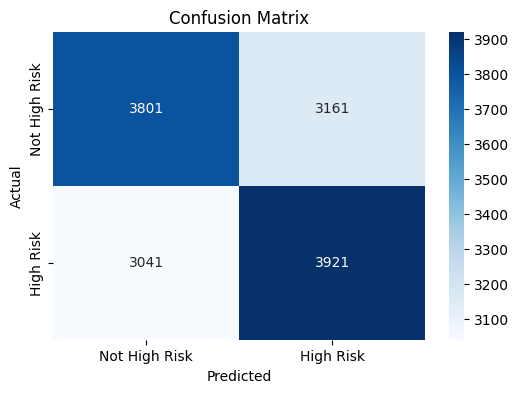

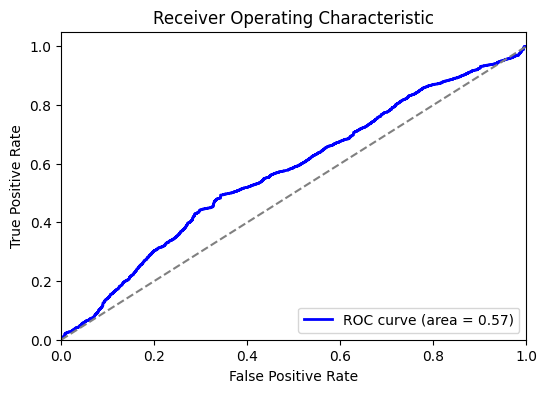

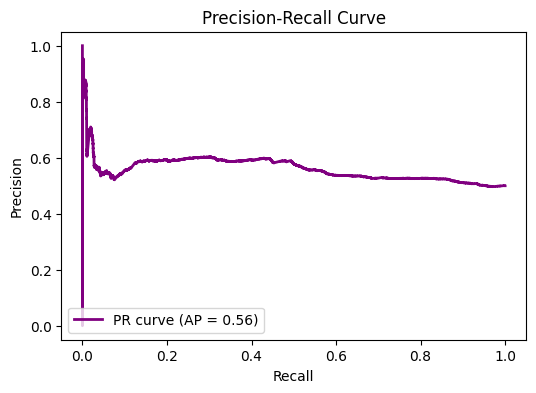


==== Evaluating DecisionTree on Test Set ====
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      6962
           1       0.99      0.80      0.88      6962

    accuracy                           0.89     13924
   macro avg       0.91      0.89      0.89     13924
weighted avg       0.91      0.89      0.89     13924



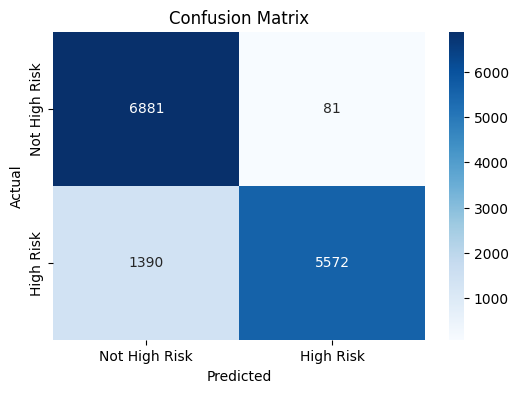

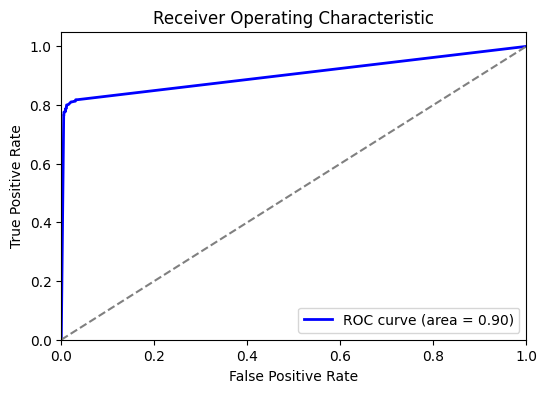

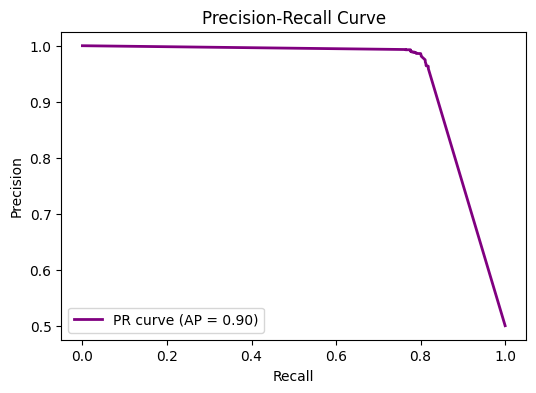


==== Evaluating RandomForest on Test Set ====
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      6962
           1       0.99      0.84      0.91      6962

    accuracy                           0.92     13924
   macro avg       0.93      0.92      0.92     13924
weighted avg       0.93      0.92      0.92     13924



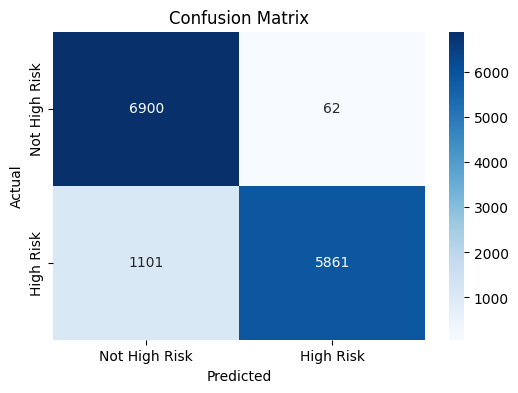

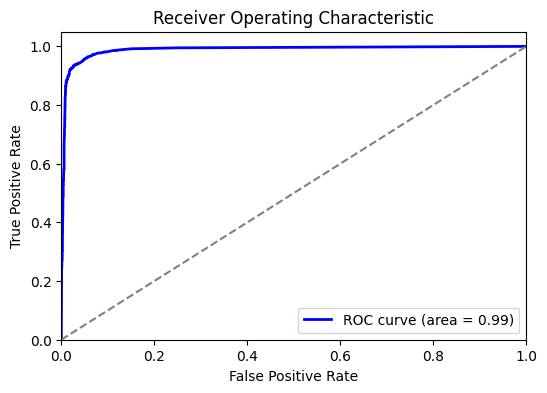

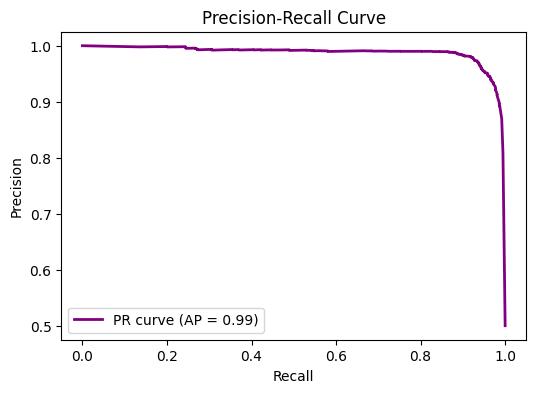


==== Evaluating GradientBoosting on Test Set ====
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      6962
           1       0.93      0.90      0.92      6962

    accuracy                           0.92     13924
   macro avg       0.92      0.92      0.92     13924
weighted avg       0.92      0.92      0.92     13924



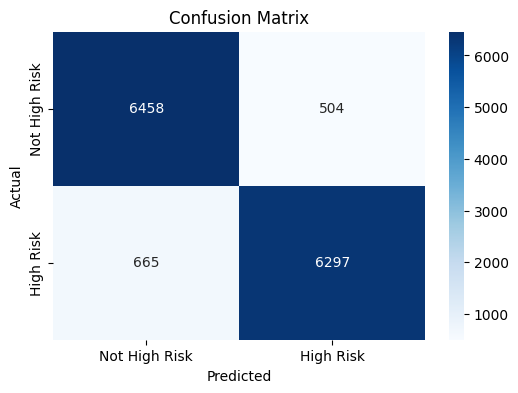

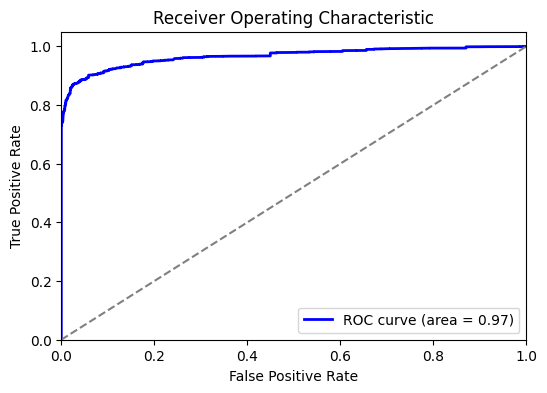

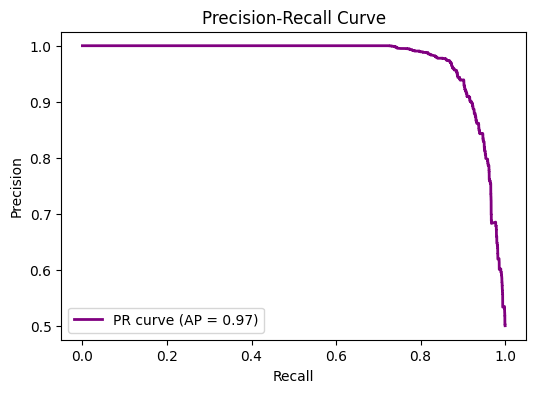


==== Evaluating XGBoost on Test Set ====
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6962
           1       0.99      0.93      0.96      6962

    accuracy                           0.96     13924
   macro avg       0.96      0.96      0.96     13924
weighted avg       0.96      0.96      0.96     13924



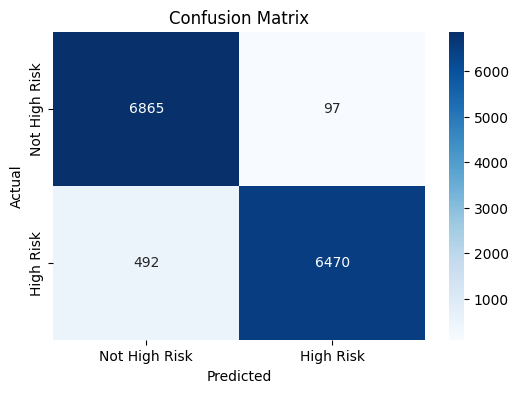

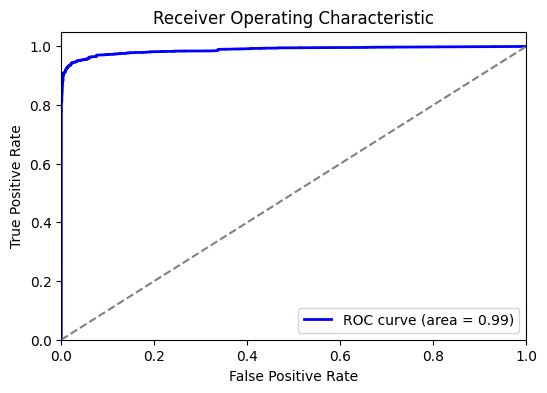

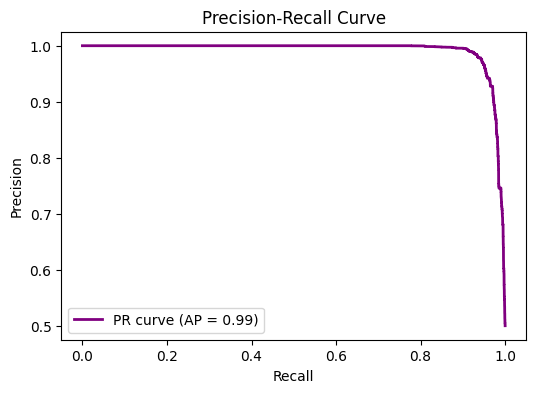


==== Evaluating VotingClassifier on Test Set ====
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      6962
           1       0.99      0.92      0.95      6962

    accuracy                           0.95     13924
   macro avg       0.96      0.95      0.95     13924
weighted avg       0.96      0.95      0.95     13924



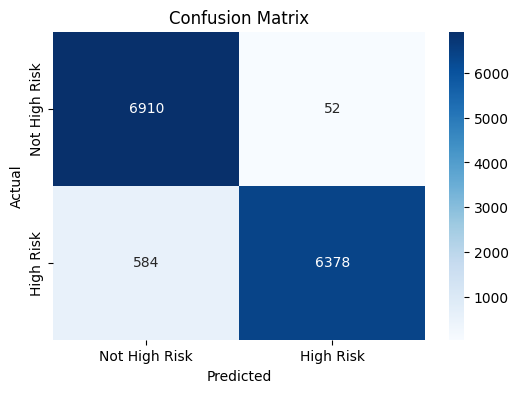

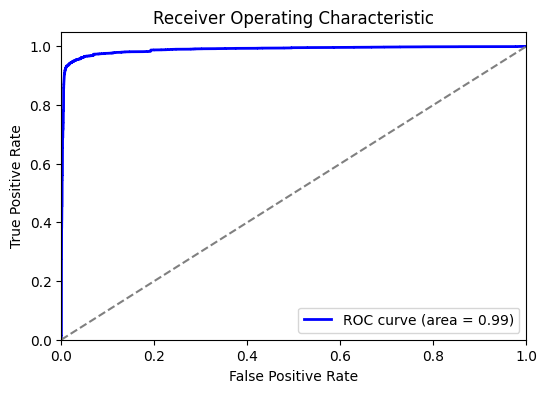

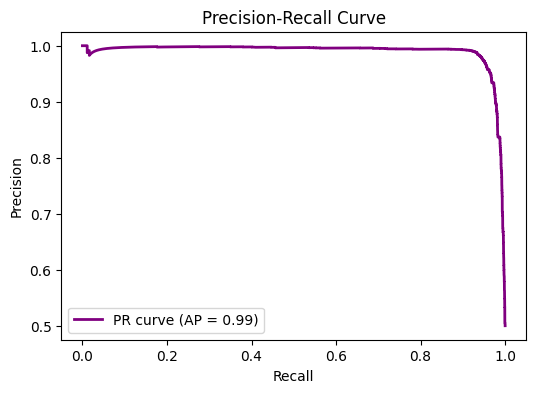


==== Evaluating StackingClassifier on Test Set ====
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      6962
           1       0.99      0.91      0.95      6962

    accuracy                           0.95     13924
   macro avg       0.95      0.95      0.95     13924
weighted avg       0.95      0.95      0.95     13924



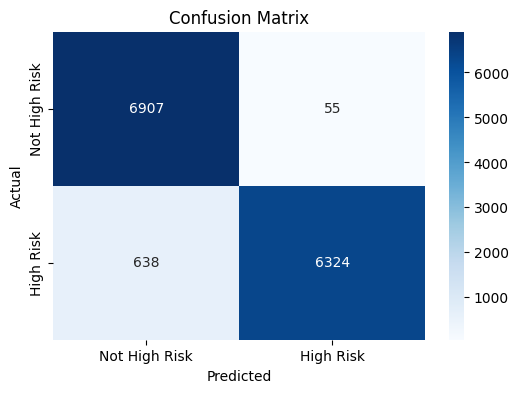

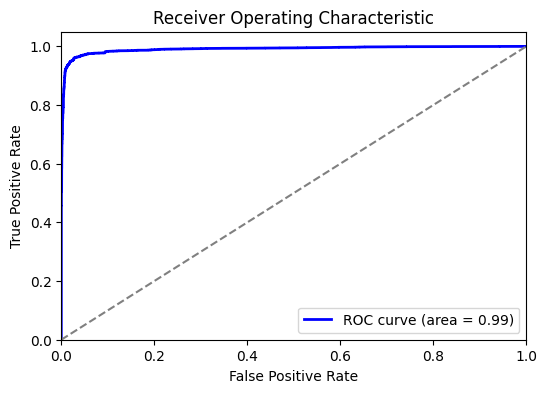

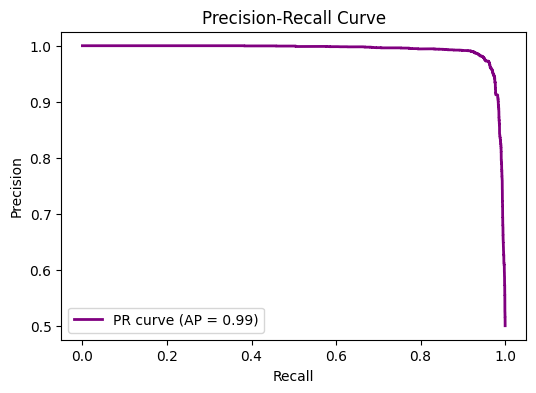

In [14]:
# Class names
class_names = ["Not High Risk", "High Risk"]

# Folder path
model_dir = "models"

# Models to evaluate
selected_models = ["LogisticRegression", "DecisionTree", "RandomForest", "GradientBoosting", "XGBoost",
                   "VotingClassifier", "StackingClassifier"]

# Evaluate saved models on test set
for name in selected_models:
    print(f"\n==== Evaluating {name} on Test Set ====")
    model_path = os.path.join(model_dir, f"{name}_model.pkl")
    
    if os.path.exists(model_path):
        loaded_model = joblib.load(model_path)
        evaluate_model_on_test(loaded_model, X_test_prep, y_test_prep, class_names=class_names)
    else:
        print(f"Model file not found: {model_path}. Skipping.")

# Model Evaluation Summary for Credit Approval Prediction

This report analyzes the performance of various classification models on the **training** and **test** datasets. Each model was evaluated using the following metrics:
- **Accuracy**
- **F1-Score**
- **ROC AUC Score**
- **Precision-Recall (AP) Score**
- **Overfitting Check** (by comparing train vs test performance)

---

## Model Performance Summary

| Model                | Train Acc | Test Acc | Train F1 | Test F1 | ROC Train / Test | PR (AP) Train / Test | Overfitting |
|---------------------|-----------|----------|----------|---------|------------------|-----------------------|--------------|
| **LogisticRegression** | 0.56    | 0.55     | 0.56     | 0.55    | 0.60 / 0.57      | 0.60 / 0.56           | Not overfitting, but underperforming |
| **Decision Tree**      | 0.98    | 0.89     | 0.98     | 0.89    | 0.99 / 0.90      | 0.98 / 0.90           | Mild overfitting |
| **Random Forest**      | 0.99    | 0.92     | 0.99     | 0.92    | 1.00 / 0.99      | 1.00 / 0.99           | Slight overfitting |
| **Gradient Boosting**  | 0.88    | 0.92     | 0.88     | 0.92    | 0.96 / 0.97      | 0.96 / 0.97           |  Excellent generalization |
| **XGBoost**            | 0.98    | 0.96     | 0.98     | 0.96    | 1.00 / 0.99      | 1.00 / 0.99           | Minimal overfitting |
| **Voting Classifier**  | 0.99    | 0.95     | 0.99     | 0.95    | 1.00 / 0.99      | 1.00 / 0.99           | Slight overfitting but high performance |
| **Stacking Classifier**| 0.99    | 0.95     | 0.99     | 0.95    | 1.00 / 0.99      | 1.00 / 0.99           | Slight overfitting but high performance |

---

## Top 3 Performing Models

Based on the evaluation metrics and generalization to the test set, the **top 3 models** are:

1. **XGBoost**
   - Excellent performance and minimal overfitting.
2. **Gradient Boosting**
   - Balanced precision and recall, generalizes very well to unseen data.
3. **VotingClassifier / StackingClassifier** *(tie)*
   - Strong ensemble models with high accuracy and F1-scores, slightly overfitting but stable.

---

## Conclusion

The evaluation shows that **ensemble-based models**—especially **XGBoost**, **Gradient Boosting**, and the ensemble Voting/Stacking classifiers—deliver the best results. These models not only achieve **high accuracy and F1-scores**, but also show **good generalization** from training to testing, making them well-suited for deployment in real-world credit approval prediction systems.

Logistic Regression, while interpretable, lacks predictive power for this dataset. Decision Trees and Random Forests are strong, but slightly overfit. The **best trade-off between performance and generalization** is achieved with **XGBoost and Gradient Boosting**.
